In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import spacy
import en_core_web_sm
import warnings 
import gensim
import time
import re
import os
import random
import seaborn as sns
import multiprocessing
import warnings
from nltk.tokenize import sent_tokenize, word_tokenize, regexp_tokenize
from gensim.models import Word2Vec
from gensim.models.phrases import Phrases, Phraser
from collections import Counter
from collections import defaultdict  # For word frequency
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

sns.set_style("darkgrid")
warnings.filterwarnings(action = 'ignore') 

# 1. Loading the data

In [2]:
%%time
data = pd.DataFrame()
for root, dirs, files in os.walk("./data/"):
        for file in files:
            if file.endswith(".csv"):
                data = data.append(pd.read_csv("./data/" + file))
print(data.shape)
data.head()

(2946207, 21)
Wall time: 32 s


,external_author_id,author,content,region,language,publish_date,harvested_date,following,followers,updates,...,account_type,retweet,account_category,new_june_2018,alt_external_id,tweet_id,article_url,tco1_step1,tco2_step1,tco3_step1
0,906000000000000000,10_GOP,"""We have a sitting Democrat US Senator on tria...",Unknown,English,10/1/2017 19:58,10/1/2017 19:59,1052,9636,253,...,Right,0,RightTroll,0,905874659358453760,914580356430536707,http://twitter.com/905874659358453760/statuses...,https://twitter.com/10_gop/status/914580356430...,NaN,NaN
1,906000000000000000,10_GOP,Marshawn Lynch arrives to game in anti-Trump s...,Unknown,English,10/1/2017 22:43,10/1/2017 22:43,1054,9637,254,...,Right,0,RightTroll,0,905874659358453760,914621840496189440,http://twitter.com/905874659358453760/statuses...,https://twitter.com/damienwoody/status/9145685...,NaN,NaN
2,906000000000000000,10_GOP,Daughter of fallen Navy Sailor delivers powerf...,Unknown,English,10/1/2017 22:50,10/1/2017 22:51,1054,9637,255,...,Right,1,RightTroll,0,905874659358453760,914623490375979008,http://twitter.com/905874659358453760/statuses...,https://twitter.com/10_gop/status/913231923715...,NaN,NaN
3,906000000000000000,10_GOP,JUST IN: President Trump dedicates Presidents ...,Unknown,English,10/1/2017 23:52,10/1/2017 23:52,1062,9642,256,...,Right,0,RightTroll,0,905874659358453760,914639143690555392,http://twitter.com/905874659358453760/statuses...,https://twitter.com/10_gop/status/914639143690...,NaN,NaN
4,906000000000000000,10_GOP,"19,000 RESPECTING our National Anthem! #StandF...",Unknown,English,10/1/2017 2:13,10/1/2017 2:13,1050,9645,246,...,Right,1,RightTroll,0,905874659358453760,914312219952861184,http://twitter.com/905874659358453760/statuses...,https://twitter.com/realDonaldTrump/status/914...,NaN,NaN


# 2. Cleaning/pre-processing

In [3]:
start_time = time.time()

In [4]:
cores = multiprocessing.cpu_count() # Count the number of cores in a computer
cores

12

### Work with English language only

In [5]:
data['language'].unique()

array(['English', 'Russian', 'Serbian', 'Ukrainian', 'Tagalog (Filipino)',
       'Albanian', 'Italian', 'Romanian', 'Spanish', 'Catalan', 'German',
       'Estonian', 'French', 'Norwegian', 'Vietnamese', 'Dutch', 'Arabic',
       'Uzbek', 'Bulgarian', 'Macedonian', 'Farsi (Persian)', 'Turkish',
       'LANGUAGE UNDEFINED', 'Czech', 'Somali', 'Lithuanian', 'Croatian',
       'Slovak', 'Icelandic', 'Slovenian', 'Japanese', 'Indonesian',
       'Pushto', 'Hungarian', 'Finnish', 'Latvian', 'Portuguese',
       'Danish', 'Swedish', 'Malay', 'Polish', 'Korean', 'Hebrew', 'Urdu',
       'Kurdish', 'Hindi', 'Greek', 'Simplified Chinese', 'Thai',
       'Gujarati', 'Bengali', 'Traditional Chinese', 'Kannada', 'Tamil',
       'Telugu', 'Malayalam'], dtype=object)

In [6]:
data = data[data.language=='English']
print(data.shape)

(2116867, 21)


- Only considering the English language

### Check null values

In [7]:
data.isnull().sum()

external_author_id          0
author                      0
content                     1
region                   1136
language                    0
publish_date                0
harvested_date              0
following                   0
followers                   0
updates                     0
post_type             1264331
account_type                0
retweet                     0
account_category            0
new_june_2018               0
alt_external_id             0
tweet_id                    0
article_url                 0
tco1_step1             758807
tco2_step1            1665942
tco3_step1            2102792
dtype: int64

- We will work with the content of each tweets, and it has only 1 null value, so we're gonna ignore it

### Lemmatize, remove urls, stopwords, non-alphabetic-characters and tweets that has less than 3 words

In [8]:
nlp = en_core_web_sm.load(disable=['ner', 'parser'])
# disabling Named Entity Recognition for speed

def cleaning(doc):
    # Lemmatizes and removes stopwords
    # doc needs to be a spacy Doc object
    txt = [token.lemma_ for token in doc if not token.is_stop]
    # Word2Vec uses context words to learn the vector representation of a target word,
    # if a sentence is only one or two words long,
    # the benefit for the training is very small
    if len(txt) > 2:
        return ' '.join(txt)

In [9]:
%%time
brief_cleaning = (re.sub("[^A-Za-z]+", ' ', (re.sub(r'(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:\'".,<>?«»“”‘’]))', ' ', str(row)))).lower() for row in data['content'])
textlist = [cleaning(doc) for doc in nlp.pipe(brief_cleaning, batch_size=100000, n_threads=cores-1)]
textlist = list(filter(None, textlist)) # removing the null tweets
textlist = [' '.join(w for w in word.split() if len(w)>2) for word in textlist] # removing words that has less than 3 alphabet

Wall time: 22min 6s


- Taking advantage of spaCy .pipe() attribute to speed-up the cleaning process:

In [10]:
data_clean = pd.DataFrame({'clean': textlist})
data_clean = data_clean.dropna().drop_duplicates()
data_clean.shape

(1550298, 1)

In [11]:
data['content'].head()

0    "We have a sitting Democrat US Senator on tria...
1    Marshawn Lynch arrives to game in anti-Trump s...
2    Daughter of fallen Navy Sailor delivers powerf...
3    JUST IN: President Trump dedicates Presidents ...
4    19,000 RESPECTING our National Anthem! #StandF...
Name: content, dtype: object

In [12]:
data_clean['clean'].head()

0    sit democrat senator trial corruption barely h...
1    marshawn lynch arrive game anti trump shirt ju...
2    daughter fallen navy sailor deliver powerful m...
3    president trump dedicate presidents cup golf t...
4            respect national anthem standforouranthem
Name: clean, dtype: object

### Detecting the phrases

In [13]:
%%time
sent = [row.split() for row in data_clean['clean']]

Wall time: 4.22 s


In [14]:
%%time
phrases = Phrases(sent, min_count=50, progress_per=10000)

Wall time: 19.2 s


In [15]:
len(phrases.vocab)

5622349

In [16]:
%%time
bigram = Phraser(phrases)
sentences = bigram[sent]

Wall time: 40 s


In [17]:
for i in range(5):
    print(sentences[i])

['sit', 'democrat', 'senator', 'trial', 'corruption', 'barely', 'hear', 'peep', 'mainstream_medium', 'nedryun']
['marshawn_lynch', 'arrive', 'game', 'anti_trump', 'shirt', 'judge', 'sag', 'pant', 'shirt', 'lynch', 'belt']
['daughter', 'fallen', 'navy', 'sailor', 'deliver', 'powerful', 'monologue', 'anthem_protest', 'burn', 'nfl', 'packers', 'gear', 'boycottnfl']
['president_trump', 'dedicate', 'presidents', 'cup', 'golf', 'tournament', 'trophy', 'people', 'florida', 'texas', 'puerto_rico']
['respect', 'national_anthem', 'standforouranthem']


- The goal of Phraser() is to cut down memory consumption of Phrases(), by discarding model state not strictly needed for the bigram detection task.
- As we can see national and anthem were two different words, but they are merged into national_anthem (as phrase)

### What is the word frequency in the data after cleaning?

In [18]:
%%time
word_freq = defaultdict(int)
for sentence in sentences:
    for word in sentence:
        word_freq[word] += 1
len(word_freq)

Wall time: 30.8 s


705341

In [19]:
sorted(word_freq, key=word_freq.get, reverse=True)[:10]

['news',
 'trump',
 'man',
 'say',
 'new',
 'sport',
 'police',
 'workout',
 'amp',
 'people']

# 3. Training the model

In [20]:
w2v_model = Word2Vec(min_count=10, # words frequency to be considered
                     window=2, # skip-gram
                     size=150, # dimension of feature vector of each word
                     negative=5, # noise words, negative sampling
                     workers=cores-1) # number of cores to be used

In [21]:
%%time
w2v_model.build_vocab(sentences, progress_per=10000)

Wall time: 34.1 s


In [22]:
%%time
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=15)

Wall time: 9min 24s


(154707047, 172716015)

In [23]:
w2v_model.init_sims(replace=True)

- As we do not plan to train the model any further, we are calling init_sims(), which will make the model much more memory-efficient

In [24]:
w2v_model.save("./data/model/word2vec.model")

- saving the model for further use, so we don't have to generate again

# 4. Exploring the model

In [25]:
print(w2v_model)

Word2Vec(vocab=47404, size=150, alpha=0.025)


### Most similar to

In [26]:
w2v_model.wv.most_similar(positive=["trump"])

[('donald_trump', 0.8196240067481995),
 ('president_trump', 0.7485881447792053),
 ('donaldtrump', 0.6768622398376465),
 ('realdonaldtrump', 0.6348617672920227),
 ('djt', 0.5977342128753662),
 ('romney', 0.5724830627441406),
 ('potu', 0.5631394386291504),
 ('trumps', 0.5564202070236206),
 ('presidenttrump', 0.5550803542137146),
 ('trump_supporter', 0.538875937461853)]

### Similarity

In [27]:
w2v_model.wv.similarity('trump', 'election')

0.372691

### Odd-one-out

In [28]:
w2v_model.wv.doesnt_match(['trump', 'hilary', 'election'])

'hilary'

### Analogy difference

In [29]:
w2v_model.wv.most_similar(positive=["king", "man"], negative=["women"], topn=3)

[('neighbor', 0.4454706907272339),
 ('cop', 0.4395963251590729),
 ('guy', 0.433019757270813)]

### t-SNE visualizations
t-SNE is a non-linear dimensionality reduction algorithm that attempts to represent high-dimensional data and the underlying relationships between vectors in a lower-dimensional space.

In [30]:
def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 150), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 150 to 15 dimensions with PCA
    reduc = PCA(n_components=15).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))

### 10 Most similar words vs. some random words

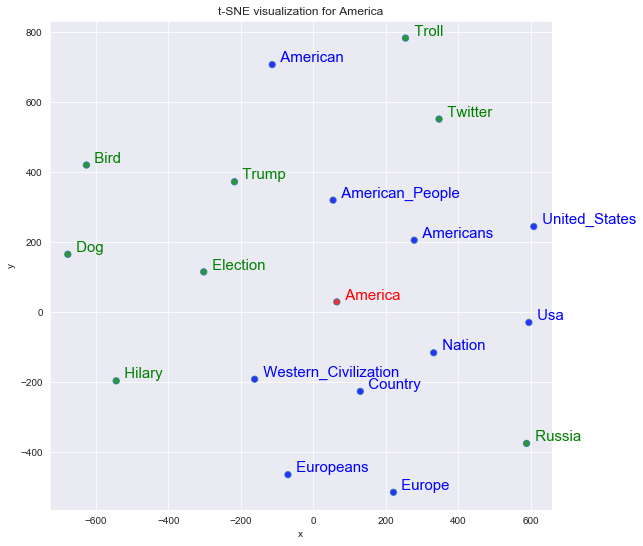

In [31]:
tsnescatterplot(w2v_model, 'america', ['dog', 'bird', 'trump', 'election', 'hilary', 'twitter', 'russia', 'troll'])

### 10 Most similar words vs. 10 most dissimilar

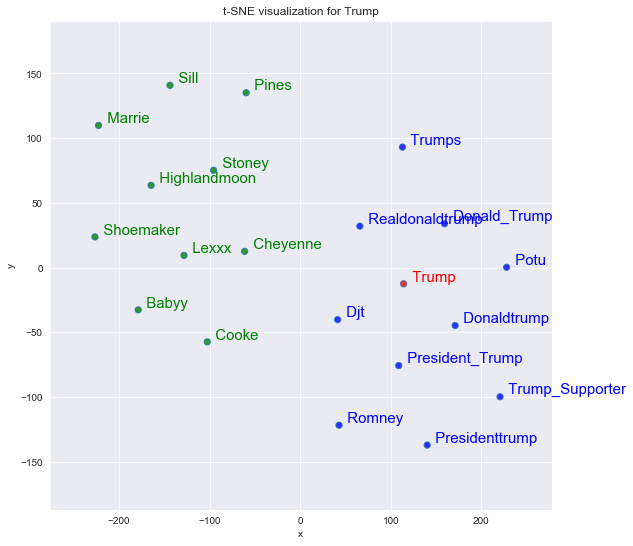

In [32]:
tsnescatterplot(w2v_model, 'trump', [i[0] for i in w2v_model.wv.most_similar(negative=["trump"])])

### Finding bias and random queries

In [33]:
w2v_model.wv.most_similar(positive=["leader"], topn=1)

[('leadership', 0.617702066898346)]

In [34]:
w2v_model.wv.most_similar(positive=['republican', 'president'], topn=2)

[('presidency', 0.6537885665893555), ('republicans', 0.6492531299591064)]

In [35]:
w2v_model.wv.most_similar(positive=['republican', 'president'], negative=['democrat'], topn=2)

[('president_elect', 0.6203805804252625), ('presidency', 0.5750123858451843)]

In [36]:
w2v_model.wv.most_similar(positive=['democrat', 'president'], negative=['republican'], topn=2)

[('presidency', 0.5010323524475098), ('prez', 0.46725863218307495)]

In [37]:
w2v_model.wv.most_similar(positive=['man', 'career'], topn=5)

[('person', 0.5841429829597473),
 ('woman', 0.55961674451828),
 ('teenager', 0.5141026377677917),
 ('girl', 0.5090662240982056),
 ('teen_girl', 0.5032057166099548)]

In [38]:
w2v_model.wv.most_similar(positive=['woman', 'king'], negative=['man'], topn=10)

[('elder', 0.4060704708099365),
 ('pan', 0.359524130821228),
 ('warren', 0.3500211238861084),
 ('lewis', 0.33974483609199524),
 ('afro', 0.3367197811603546),
 ('nat', 0.3306848406791687),
 ('queen', 0.3248124122619629),
 ('saudi_king', 0.31509289145469666),
 ('women', 0.3137485384941101),
 ('black_woman', 0.3093785345554352)]

In [39]:
w2v_model.wv.most_similar(positive=['fakenews'], topn=10)

[('fakenew', 0.7107083797454834),
 ('freedomofthepress', 0.7012434601783752),
 ('fakenewsmedia', 0.6720388531684875),
 ('cnn_msnbc', 0.6520283818244934),
 ('fake_news', 0.6515477895736694),
 ('fakenewscnn', 0.6350615620613098),
 ('veryfakenew', 0.6279435157775879),
 ('veryfakenews', 0.6010816097259521),
 ('boycottcnn', 0.599384605884552),
 ('fakepoll', 0.5904039740562439)]

# 5. Google's trained Word2Vec model vs our Word2Vec model
- https://mccormickml.com/2016/04/12/googles-pretrained-word2vec-model-in-python/

In [40]:
%%time
model = gensim.models.KeyedVectors.load_word2vec_format('./data/GoogleNews-vectors-negative300.bin', binary=True)

Wall time: 52.6 s


In [41]:
print(model.wv.most_similar(positive=['woman', 'king'], negative=['man'], topn=1))
print(w2v_model.wv.most_similar(positive=['woman', 'king'], negative=['man'], topn=1))

[('queen', 0.7118192911148071)]
[('elder', 0.4060704708099365)]


In [42]:
print(model.wv.most_similar(positive=['republican', 'president'], topn=1))
print(w2v_model.wv.most_similar(positive=['republican', 'president'], topn=1))

[('President', 0.6268802881240845)]
[('presidency', 0.6537885665893555)]


In [43]:
print(model.wv.doesnt_match(['clinton', 'trump', 'russia', 'china', 'america', 'election', 'england', 'obama']))
print(w2v_model.wv.doesnt_match(['clinton', 'trump', 'russia', 'china', 'america', 'election', 'england', 'obama']))

election
england


In [44]:
print(model.wv.most_similar(['racism']))
print(w2v_model.wv.most_similar(['racism']))

[('homophobia', 0.7546095848083496), ('Racism', 0.7497609853744507), ('institutionalized_racism', 0.7491472959518433), ('bigotry', 0.7266136407852173), ('racist', 0.7217566967010498), ('racial_discrimination', 0.713367223739624), ('racisim', 0.7058967351913452), ('racial_bigotry', 0.7057559490203857), ('racial_intolerance', 0.703029990196228), ('racial_prejudice', 0.7019556760787964)]
[('racism_sexism', 0.7247349619865417), ('white_supremacy', 0.7185237407684326), ('bigotry', 0.6884170174598694), ('oppression', 0.6714835166931152), ('homophobia', 0.6711241006851196), ('prejudice', 0.6643327474594116), ('segregation', 0.6615561842918396), ('white_privilege', 0.6452728509902954), ('antisemitism', 0.6409633755683899), ('xenophobia', 0.6370413899421692)]


In [45]:
print(model.wv.most_similar(['cop']))
print(w2v_model.wv.most_similar(['cop']))

[('cops', 0.7751113176345825), ('NYPD_cop', 0.6635390520095825), ('Cop', 0.6613665223121643), ('policeman', 0.6574563384056091), ('detective', 0.65337073802948), ('homicide_detective', 0.6199662685394287), ('narc', 0.6102039813995361), ('crooked_cop', 0.6002154350280762), ('lawman', 0.5969462394714355), ('undercover_cop', 0.5811244249343872)]
[('police_officer', 0.8084465265274048), ('officer', 0.7361173033714294), ('police', 0.7227240204811096), ('nypd_cop', 0.7154238820075989), ('nypd_officer', 0.7015337944030762), ('policeman', 0.6915027499198914), ('cops', 0.6889235973358154), ('lapd_officer', 0.6842789649963379), ('duty_officer', 0.6736580729484558), ('duty_cop', 0.6585602760314941)]


In [46]:
print(model.wv.most_similar(['maid']))
print(w2v_model.wv.most_similar(['maid']))

[('housekeeper', 0.7441761493682861), ('housemaid', 0.7086839079856873), ('maids', 0.6571398973464966), ('chambermaid', 0.6350985765457153), ('maid_servant', 0.5534963607788086), ('waitress', 0.5472760796546936), ('prostitute', 0.5466710329055786), ('maidservant', 0.5454322099685669), ('Filipino_maid', 0.5363936424255371), ('housecleaner', 0.5321150422096252)]
[('photograph', 0.4353492856025696), ('concierge', 0.3761539161205292), ('hooker', 0.36809709668159485), ('prostitute', 0.34909528493881226), ('cleaner', 0.33550429344177246), ('neighbour', 0.334225594997406), ('lady_liberty', 0.3340739607810974), ('marry', 0.331928014755249), ('housekeeper', 0.33103322982788086), ('victoria_secret', 0.33086958527565)]


In [47]:
print(model.wv.most_similar(['leader']))
print(w2v_model.wv.most_similar(['leader']))

[('leadership', 0.5659864544868469), ('Leader', 0.5506060123443604), ('leaders', 0.5479303598403931), ('premier', 0.5060886740684509), ('president', 0.4555639624595642), ('leading', 0.4482613503932953), ('parliamentarian', 0.4425082504749298), ('standard_bearer', 0.4424498379230499), ('pioneer', 0.423666775226593), ('SIR_Menzies_Campbell', 0.4223523736000061)]
[('leadership', 0.617702066898346), ('member', 0.538918137550354), ('politician', 0.537382960319519), ('faction', 0.5318265557289124), ('ally', 0.4984540641307831), ('candidate', 0.4977152645587921), ('delegation', 0.4917888045310974), ('dictator', 0.4841686189174652), ('lawmaker', 0.4818316698074341), ('president', 0.4794214069843292)]


In [48]:
print(model.wv.most_similar(positive=['wife', 'husband'], negative=['woman'], topn=5))
print(w2v_model.wv.most_similar(positive=['wife', 'husband'], negative=['woman'], topn=5))

[('sons', 0.6452116966247559), ('father', 0.6188110113143921), ('fiancée', 0.6155856847763062), ('son', 0.610623836517334), ('fiancé', 0.6072103977203369)]
[('boyfriend', 0.5529972910881042), ('father', 0.5219230055809021), ('estranged', 0.518871009349823), ('girlfriend', 0.5114659070968628), ('dad', 0.5078303813934326)]


In [49]:
print("Process time: %s" % (time.time()-start_time))

Process time: 2101.354907274246
